In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 126kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
     |████████████████████████████████| 10.5MB 2.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.1 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5


In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
dataset_filename = os.listdir("/content/drive/My Drive/")[0]
#dataset_path = '../input/sentiment140/training.1600000.processed.noemoticon.csv'
dataset_path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/My Drive/training.1600000.processed.noemoticon.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))


CPU times: user 543 ms, sys: 2.52 ms, total: 546 ms
Wall time: 548 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

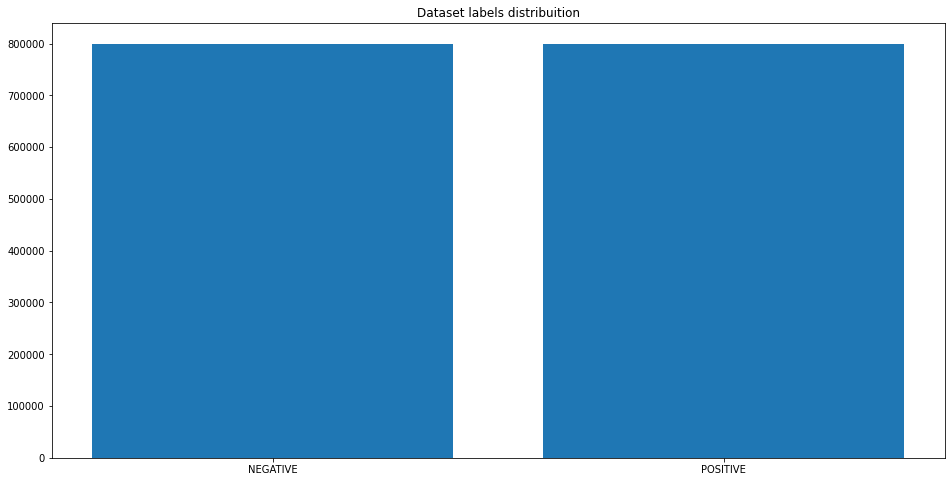

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 42.8 s, sys: 177 ms, total: 42.9 s
Wall time: 43 s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.72 s, sys: 288 ms, total: 3.01 s
Wall time: 3.01 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)


2020-09-03 11:24:59,271 : INFO : collecting all words and their counts
2020-09-03 11:24:59,274 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-03 11:24:59,305 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-09-03 11:24:59,328 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-09-03 11:24:59,353 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-09-03 11:24:59,373 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-09-03 11:24:59,398 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-09-03 11:24:59,417 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-09-03 11:24:59,441 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-09-03 11:24:59,471 : INFO : PROGRESS: at s

In [17]:
  words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-09-03 11:25:32,610 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-09-03 11:25:33,662 : INFO : EPOCH 1 - PROGRESS: at 3.80% examples, 305043 words/s, in_qsize 14, out_qsize 4
2020-09-03 11:25:34,711 : INFO : EPOCH 1 - PROGRESS: at 8.80% examples, 346405 words/s, in_qsize 15, out_qsize 0
2020-09-03 11:25:35,721 : INFO : EPOCH 1 - PROGRESS: at 13.68% examples, 362824 words/s, in_qsize 14, out_qsize 1
2020-09-03 11:25:36,735 : INFO : EPOCH 1 - PROGRESS: at 18.11% examples, 362038 words/s, in_qsize 15, out_qsize 0
2020-09-03 11:25:37,741 : INFO : EPOCH 1 - PROGRESS: at 22.55% examples, 362271 words/s, in_qsize 16, out_qsize 0
2020-09-03 11:25:38,742 : INFO : EPOCH 1 - PROGRESS: at 27.10% examples, 364149 words/s, in_qsize 15, out_qsize 0
2020-09-03 11:25:39,748 : INFO : EPOCH 1 - PROGRESS: at 31.86% examples, 367799 words/s, in_qsize 14, out_qsize 1
2020-09-03 11:25:40,767 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 23min 18s, sys: 6.38 s, total: 23min 24s
Wall time: 12min 7s


(263120702, 295270528)

In [19]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-09-03 11:38:18,869 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5681506991386414),
 ('loves', 0.5640884637832642),
 ('loved', 0.5415631532669067),
 ('amazing', 0.5185268521308899),
 ('adore', 0.5144675970077515),
 ('looove', 0.49014315009117126),
 ('loveee', 0.47356343269348145),
 ('awesome', 0.4692952036857605),
 ('loooove', 0.4425589442253113),
 ('lovee', 0.440317302942276)]

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17.4 s, sys: 86 ms, total: 17.5 s
Wall time: 17.5 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 26.6 s, sys: 626 ms, total: 27.3 s
Wall time: 27.3 s


In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-09-03 11:40:56,589 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7509WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 12:03:11,224 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1305s 1s/step - loss: 0.5028 - accuracy: 0.7509 - val_loss: 0.4620 - val_accuracy: 0.7808
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7681WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 12:24:50,591 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1298s 1s/step - loss: 0.4778 - accuracy: 0.7681 - val_loss: 0.4578 - val_accuracy: 0.7844
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.7725WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 12:46:19,504 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1288s 1s/step - loss: 0.4711 - accuracy: 0.7725 - val_loss: 0.4539 - val_accuracy: 0.7865
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.7750WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 13:07:44,565 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1284s 1s/step - loss: 0.4672 - accuracy: 0.7750 - val_loss: 0.4487 - val_accuracy: 0.7884
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.7763WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 13:29:15,100 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1289s 1s/step - loss: 0.4650 - accuracy: 0.7763 - val_loss: 0.4488 - val_accuracy: 0.7888
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7774WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 13:50:47,237 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1291s 1s/step - loss: 0.4630 - accuracy: 0.7774 - val_loss: 0.4480 - val_accuracy: 0.7895
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7781WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 14:12:18,994 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1291s 1s/step - loss: 0.4617 - accuracy: 0.7781 - val_loss: 0.4455 - val_accuracy: 0.7910
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.7791WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-09-03 14:33:46,165 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 1286s 1s/step - loss: 0.4606 - accuracy: 0.7791 - val_loss: 0.4459 - val_accuracy: 0.7902
CPU times: user 3h 8min 23s, sys: 30min 30s, total: 3h 38min 54s
Wall time: 2h 52min 25s


In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 103s 329ms/step - loss: 0.4445 - accuracy: 0.7912

ACCURACY: 0.791196882724762
LOSS: 0.44445717334747314
CPU times: user 1min 28s, sys: 15.8 s, total: 1min 44s
Wall time: 1min 43s


In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [37]:
predict("I love the music")

{'elapsed_time': 0.42334890365600586,
 'label': 'POSITIVE',
 'score': 0.9729598760604858}

In [38]:
predict("I hate the rain")

{'elapsed_time': 0.14288902282714844,
 'label': 'NEGATIVE',
 'score': 0.008977441117167473}

In [39]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.14207983016967773,
 'label': 'NEGATIVE',
 'score': 0.2995266616344452}

In [40]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 74s 2s/step
CPU times: user 1min 4s, sys: 22.8 s, total: 1min 26s
Wall time: 1min 18s


In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

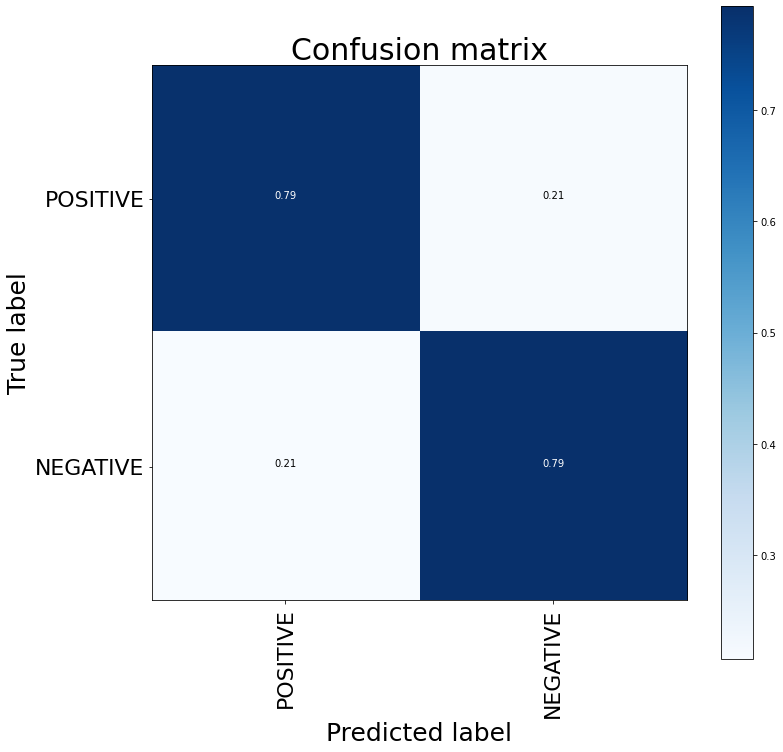

CPU times: user 1.23 s, sys: 9.46 ms, total: 1.24 s
Wall time: 1.26 s


In [42]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [43]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.791196875

In [45]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-09-03 14:48:10,750 : INFO : saving Word2Vec object under model.w2v, separately None
2020-09-03 14:48:10,762 : INFO : not storing attribute vectors_norm
2020-09-03 14:48:10,776 : INFO : not storing attribute cum_table
2020-09-03 14:48:11,914 : INFO : saved model.w2v


In [47]:
predict("I enjoy watching cricket")

{'elapsed_time': 0.40236926078796387,
 'label': 'POSITIVE',
 'score': 0.9674584865570068}

In [48]:
predict("I will not be pressurized")

{'elapsed_time': 0.1961522102355957,
 'label': 'NEUTRAL',
 'score': 0.5469185709953308}